In [1]:
# Run only once to avoid changing working directory. If required restart kernel and run again
import os
os.chdir(os.path.dirname(os.getcwd()))
repo_dir = os.getcwd()
print(repo_dir)

/home/diptesh/IEEE/src/drone


In [2]:
train_with_mask = repo_dir + '/assets/Dataset/maskdata/maskdata/train/with_mask/'
train_without_mask = repo_dir + '/assets/Dataset/maskdata/maskdata/train/without_mask'
test_with_mask = repo_dir + '/assets/Dataset/maskdata/maskdata/test/with_mask'
test_without_mask = repo_dir + '/assets/Dataset/maskdata/maskdata/test/without_mask'
print(len(os.listdir(train_with_mask)))
print(len(os.listdir(train_without_mask)))
print(len(os.listdir(test_with_mask)))
print(len(os.listdir(test_without_mask)))

341
275
66
132


0
(275, 183)
1
(183, 275)
2
(320, 428)
3
(320, 428)
4
(639, 639)
5
(320, 428)


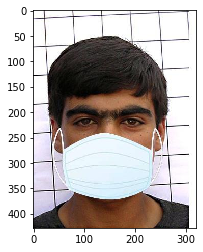

In [3]:
import sys
from os import listdir
from PIL import Image
import matplotlib.pyplot as plt

main_dir = train_with_mask
files = listdir(main_dir)
# you can change file extension below to read other image types
images_list = [i for i in files if i.endswith('.jpg')] ## output file names only
i = 0
for idx,image in enumerate(images_list):
  if i>5:
    break
  i = i + 1
  print(idx)
  img = Image.open(main_dir + image)
  print(img.size)
  plt.imshow(img)
  #img = img.resize((480, 600))

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,Input,AveragePooling2D
#from keras.applications import InceptionV3
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
#from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
#from tensorflow.keras.utils import to_categorical
#from sklearn.preprocessing import LabelBinarizer
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report
#from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

2021-08-14 10:53:51.340626: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/diptesh/catkin_ws/devel/lib:/home/diptesh/IEEE/devel/lib:/opt/ros/noetic/lib
2021-08-14 10:53:51.340659: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


AttributeError: module 'tensorflow.python.training.experimental.mixed_precision' has no attribute '_register_wrapper_optimizer_cls'

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [7]:
train_DIR = repo_dir + '/assets/Dataset/maskdata/maskdata/train'
test_DIR = repo_dir + '/assets/Dataset/maskdata/maskdata/test'

Image_gen = ImageDataGenerator(rescale=1.0/255.0,
                               horizontal_flip = True,
                               rotation_range = 50,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               zoom_range = 0.2,
                               fill_mode = 'nearest',
                               validation_split = 0.2)

train_generator = Image_gen.flow_from_directory(train_DIR,
                                                target_size = (224,224),
                                                batch_size = 20,
                                                class_mode = 'categorical',
                                                subset = "training")

val_generator = Image_gen.flow_from_directory(train_DIR,
                                                target_size = (224,224),
                                                batch_size = 20,
                                                class_mode = 'categorical',
                                                subset = "validation")

test_generator = Image_gen.flow_from_directory(test_DIR,
                                                target_size = (224,224),
                                                batch_size = 20,
                                                class_mode = 'categorical',
                                                )

Found 493 images belonging to 2 classes.
Found 123 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


In [8]:
input = keras.layers.Input(shape=(224,224,3))
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3), input_tensor= input)

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

2021-08-14 10:32:50.274666: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-14 10:32:50.342888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-14 10:32:50.343228: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti computeCapability: 7.5
coreClock: 1.59GHz coreCount: 24 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 268.26GiB/s
2021-08-14 10:32:50.343377: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/diptesh/catkin_ws/devel/lib:/home/diptesh/IEEE/devel/lib:/opt/ros/noetic/lib
2021-08-14 10:32:

9412608/9406464 [==============================] - 1s 0us/step


In [ ]:
model.summary()

In [ ]:
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(train_generator, batch_size=BS, validation_data=val_generator, epochs=EPOCHS,verbose = 2)

In [ ]:
model.evaluate(test_generator,batch_size= BS, verbose=2)

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(test_generator, batch_size=BS,verbose=2, )

predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
test_labels=test_generator.classes 
print(classification_report(test_labels, predIdxs))

In [ ]:
#model.save("drone_vision/saved_model", save_format="h5")

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype, name="yourInputName"))
# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 50)
print("Frozen model layers: ")
for layer in layers:
    print(layer)
print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)
# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="drone_vision/frozen_models",
                  name="frozen_graph.pb",
                  as_text=False)

In [ ]:
pb_file = 'drone_vision/frozen_models/frozen_models/frozen_graph.pb'
graph_def = tf.compat.v1.GraphDef()

try:
    with tf.io.gfile.GFile(pb_file, 'rb') as f:
        graph_def.ParseFromString(f.read())
except:
    with tf.gfile.FastGFile(pb_file, 'rb') as f:
        graph_def.ParseFromString(f.read())

# Delete weights
for i in reversed(range(len(graph_def.node))):
    if graph_def.node[i].op == 'Const':
        del graph_def.node[i]

graph_def.library.Clear()

tf.compat.v1.train.write_graph(graph_def, "/drone_vision/frozen_models/frozen_models", 'model.pbtxt', as_text=True)

In [ ]:
# Load a model imported from Tensorflow
tensorflowNet = cv2.dnn.readNetFromTensorflow('drone_vision/frozen_models/frozen_models/frozen_graph.pb')
# Input image
img = cv2.imread('assets/test_photos/frands.jpg')
rows, cols, channels = img.shape

# Use the given image as input, which needs to be blob(s).
tensorflowNet.setInput(cv2.dnn.blobFromImage(img, size=(224, 224), swapRB=True, crop=False))

# Runs a forward pass to compute the net output
networkOutput = tensorflowNet.forward()

# Loop on the outputs
for detection in networkOutput[0,0]:

    score = float(detection[2])
    if score > 0.9:

        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows

        #draw a red rectangle around detected objects
        cv2.rectangle(img, (int(left), int(top)), (int(right), int(bottom)), (0, 0, 255), thickness=2)

# Show the image with a rectagle surrounding the detected objects 
cv2.imshow('Image', img)
cv2.waitKey()
cv2.destroyAllWindows()